# Note
Previous notebook drafts have analyzed several classification methods not included here, particularly SVM methods. The SVM classifiers did not return quality results and took long times to run. They are therefore not included in this analysis.

# Defining Parameters

* **Data**: All Notes
* **Model Imbalance**: Sub-Sampling Negeatives
* **Vectorizor**: TF-IDF
* **Vectorizor Parameters**: 3000
* **Dimension Reduction Method**: Truncated SVD
* **Grid Search Scoring Parameter**: f1_weighted

In [1]:
scoring_metric = 'f1_macro'
max_features = 3000
max_iter_log = 500

# Library Calls

In [2]:
import pandas as pd
import numpy as np
import feather
import nltk
import re
import string
import yellowbrick
import sklearn
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

from sklearn.model_selection import cross_val_score, cross_validate

# Random State
random_state = 5590
solver_log = 'saga'

# Data Import and Processing
## !!!One Data Frame Import Must Be Commented Out!!!!

We define the dataframes as none for a subsqent check.

In [3]:
df_all = None
df_ds = None

In [4]:
# All Available Notes
df_all = pd.read_csv('./data/text_processed_all.csv.gz', compression='gzip', low_memory=False)

# Dishcharge Summary Notes Onlly
#df_ds = pd.read_csv('./data/text_processed_discharge_summary.csv.gz', compression='gzip', low_memory=False)

# Define Data Frame

Here we do a check to see which data frame we are analyzing, All Notes or Discharge Notes

In [5]:
if df_all is not None:
    df = df_all
else:
    df = df_ds
      
# Convert HADMID to String
df.hadm_id = df.hadm_id.astype('int64').astype(str)

# Convert Readmit_30 to Int
df.readmit_30 = df.readmit_30.astype('int')

# Functions

## Modified Tokenizer
Define a modified tokenizer function. This function will remove numbers and characters, as well as set all words to lower case.

In [6]:
def tokenize_note_events(text):
    #create a list of all characters and numbers
    num_puct_list = string.punctuation+'0123456789'
    
    # Create a dictionary aligning each numeric and chcarter to a space
    t = str.maketrans(dict.fromkeys(num_puct_list, " "))
    
    # Convert Text to lower case and apply dictionary
    text = text.lower().translate(t)
    
    #tokenize
    tokens = nltk.word_tokenize(text)
    return tokens

## Custom Stop Words
Define custom stop words

In [7]:
stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
 'is','patient','s','he','at','as','or','one','she','his','her','am', 
 'were','you','pt','pm','by','be','had','your','this','date', 'from',
 'there','an','that','p','are','have','has','h','but','o', 
 'namepattern','which','every','also', 'w', 'd', 'c', 'l', 
 'q', 'r', 'x', 't', 'm']

## Text Processing Function with Truncated SVD
The following function performs all of the prec-processing steps, using sub-sampling to balance the data. The function tokenizes the text using 1-grams and 2-grams. The function returns a processed predictor dataframe for the training and validation data, as well as the target variable for the training and validation data.

In [8]:
def text_processing_sub_sample_tr_v(df):
    # Clean the Entire Data Set of numbers, characters, carriage returns, and new lines
    df.text = df.text.fillna(' ')
    df.text = df.text.str.replace('\n',' ')
    df.text = df.text.str.replace('\r',' ')
    
    # Split into Train, Valid and Test
    ## Shuffle
    df = df.sample(n = len(df), random_state= random_state)
    df = df.reset_index(drop = True)
    
    ## Extract Data for Test and Valid Sampling
    df_v_te = df.sample(frac=0.40, random_state = random_state)
    
    ## Test Sample
    df_te = df_v_te.sample(frac = 0.5, random_state = random_state)
    
    ## Valid Sample
    df_v = df_v_te.drop(df_te.index)

    ## Training Sample
    df_tr = df.drop(df_v_te.index)
    
    # Sub-Sampling
    ## Split Data into Positive and Negative Target Returns
    rows_readmit = df_tr.readmit_30 == 1
    df_tr_pos = df_tr.loc[rows_readmit]
    df_tr_neg = df_tr.loc[~rows_readmit]
    
    # Balance the Data, and Re-merge to a single data set
    df_tr = pd.concat([df_tr_pos, 
                                df_tr_neg.sample(n = len(df_tr_pos))], 
                                axis = 0
                          )

    # shuffle the order of training samples 
    df_tr = df_tr.sample(n = len(df_tr)).reset_index(drop = True)
    
    # Initialize Vectorizer and SVD
    ## Use Modified Tokenizer, Set number of n-grams, use custom stop words
    vect = TfidfVectorizer(max_features = max_features, 
                           tokenizer = tokenize_note_events, 
                           ngram_range = (1,2),
                           stop_words=stop_words
                          )

    # Transform Text
    # Fit Vectorizer on Training Data
    vect.fit(df_tr.text.values)

    # Transform the text into vectors.
    x_tr_tf = vect.transform(df_tr.text.values)
    x_v_tf = vect.transform(df_v.text.values)
    x_te_tf  = vect.transform(df_te.text.values)

    # Define Target Variables
    y_tr = df_tr.readmit_30
    y_v = df_v.readmit_30
    y_te = df_te.readmit_30
    
    return x_tr_tf, x_v_tf, x_te_tf, y_tr, y_v, y_te, df_tr, vect

## Truncated SVD

In [9]:
def trunc_svd(x_tr, x_v, x_te, n):
    svd = TruncatedSVD(n_components = n, n_iter = 7, random_state = random_state)
    # Fit SVD on Training Data
    svd.fit(x_tr)
    
    # Transform Sparse Matrices
    x_tr_svd = svd.transform(x_tr)
    x_v_svd = svd.transform(x_v)
    x_te_svd  = svd.transform(x_te)
    
    return x_tr_svd, x_v_svd, x_te_svd

## Model Output

### Scoring Metrics
The following functions calculate the scoring metrics the models will be evlauted on.

In [10]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1)) +
            sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

### Scoring Output
The following code generates the visual output of the scoring metrics.

In [11]:
def model_output(y_tr, y_tr_preds, y_v, y_v_preds):
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_tr_preds)
    fpr_v, tpr_v, thresholds_v = roc_curve(y_v, y_v_preds)

    thresh = 0.5

    auc_t = '%.3f' %roc_auc_score(y_tr, y_tr_preds)
    auc_v = '%.3f' %roc_auc_score(y_v, y_v_preds)
    
    acc_t = '%.3f' %calc_accuracy(y_tr, y_tr_preds, thresh)
    acc_v = '%.3f' %calc_accuracy(y_v, y_v_preds, thresh)
    
    recall_raw_t = calc_recall(y_tr, y_tr_preds, thresh)
    recall_raw_v = calc_recall(y_v, y_v_preds, thresh)
    
    recall_t = '%.3f' %recall_raw_t
    recall_v = '%.3f' %recall_raw_v
    
    precision_raw_t = calc_precision(y_tr, y_tr_preds, thresh)
    precision_raw_v = calc_precision(y_v, y_v_preds, thresh)
    
    precision_t = '%.3f' %precision_raw_t
    precision_v = '%.3f' %precision_raw_v
      
    
    f1_t = '%.3f' %((precision_raw_t * recall_raw_t)/(precision_raw_t + recall_raw_t))
    f1_v = '%.3f' %((precision_raw_v * recall_raw_v)/(precision_raw_v + recall_raw_v))
    
    specificity_t = '%.3f' %calc_specificity(y_tr, y_tr_preds, thresh)
    specificity_v = '%.3f' %calc_specificity(y_v, y_v_preds, thresh)
    
    prevalence_t = '%.3f' %calc_prevalence(y_tr)
    prevalence_v = '%.3f' %calc_prevalence(y_v)
    
    
    data = {'Score':['AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'Prevalence'],
            'Train':[auc_t, acc_t, precision_t, recall_t, f1_t, specificity_t, prevalence_t],
            'Validation':[auc_v, acc_v, precision_v, recall_v,  f1_v, specificity_v, prevalence_v]
           }
    
    df = pd.DataFrame(data)
    
    print(df)

    plt.plot(fpr_tr, tpr_tr,'r-', label = 'Train AUC: %.2f'%roc_auc_score(y_tr, y_tr_preds))
    plt.plot(fpr_v, tpr_v,'b-',label = 'Valid AUC: %.2f'%roc_auc_score(y_v, y_v_preds))
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Model Execution

The following function trains a default model to the training data and generates training and validation scores.

In [12]:
def train_model_default(clf, x_tr, x_v):
    
    clf.fit(x_tr, y_tr)

    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    model_output(y_tr, y_tr_preds, y_v, y_v_preds)

The following function takes in the optimized model and generates training and validation scores


In [13]:
def opt_model_scoring(clf, x_tr, x_v):
    
    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    model_output(y_tr, y_tr_preds, y_v, y_v_preds)

The following function runs the gridsearchcv

In [14]:
def grid_search_opt(x_tr, x_v, clf, hyper_param_dict):


    # Create a Grid Search
    clf = GridSearchCV(clf, hyper_param_dict, cv=5, verbose=1,  scoring = scoring_metric, n_jobs = -1)

    # Best Model
    clf.fit(x_tr, y_tr)
    
    # Export Best Parameters to New Model
    clf_best_est = clf.best_estimator_

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    return clf_best_est

# Data Set: Discharge Notes
The following analysis will be of the data frame with all discharge notes.

## Data Processing

First the data is processed and tokenized. This will take a while.

In [15]:
df = df.sample(frac = 1, random_state = random_state)
x_tr_pre, x_v_pre, x_te_pre, y_tr, y_v, y_te, df_tr_non_xfrm, vect = text_processing_sub_sample_tr_v(df)

Then we reduce the dimensions of the sparse matrics to improve model run time.

##### 30 Dimensions

In [16]:
x_tr_svd_30, x_v_svd_30, x_te_svd_30 = trunc_svd(x_tr_pre, x_v_pre, x_te_pre, 30)

##### 300 Dimensions

In [17]:
x_tr_svd_300, x_v_svd_300, x_te_svd_300 = trunc_svd(x_tr_pre, x_v_pre, x_te_pre, 300)

## Modeling - Default Settings

### Naive Bayes

#### Pre-SVD
Naive Bayes will not run with Truncated SVD due to negative matrix values.

         Score  Train Validation
0          AUC  0.684      0.660
1     Accuracy  0.626      0.669
2    Precision  0.647      0.109
3       Recall  0.555      0.591
4           F1  0.299      0.092
5  Specificity  0.698      0.674
6   Prevalence  0.500      0.063


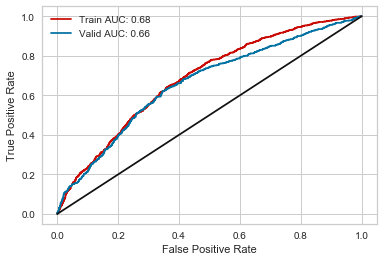

In [18]:
# Define X Values
x_tr = x_tr_pre
x_v = x_v_pre

clf = MultinomialNB()
train_model_default(clf, x_tr, x_v)

### Logistic Regression

In [19]:
# Define Classifier - Default Settings
clf = LogisticRegression(random_state = random_state, solver = solver_log, max_iter = max_iter_log)

#### Pre SVD

In [20]:
# # Define X Values
# x_tr = x_tr_pre
# x_v = x_v_pre

# train_model_default(clf, x_tr, x_v)

#### Post SVD

##### 30 Dimensions

         Score  Train Validation
0          AUC  0.714      0.689
1     Accuracy  0.662      0.633
2    Precision  0.660      0.106
3       Recall  0.671      0.647
4           F1  0.333      0.091
5  Specificity  0.654      0.632
6   Prevalence  0.500      0.063


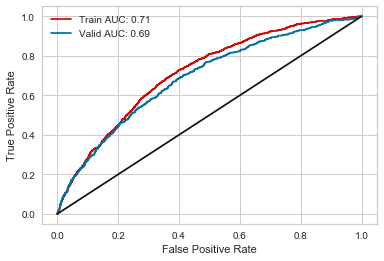

In [21]:
# Define X Values
x_tr = x_tr_svd_30
x_v = x_v_svd_30

train_model_default(clf, x_tr, x_v)

##### 300 Dimensions

In [22]:
# # Define X Values
# x_tr = x_tr_svd_300
# x_v = x_v_svd_300

# train_model_default(clf, x_tr, x_v)

###  Random Forest

In [23]:
# Define Classifier - Default Settings
clf = RandomForestClassifier(random_state = random_state, n_estimators = 100)

#### Pre SVD

In [24]:
# # Define X Values
# x_tr = x_tr_pre
# x_v = x_v_pre

# train_model_default(clf, x_tr, x_v)

#### Post SVD

##### 30 Dimensions

         Score  Train Validation
0          AUC  1.000      0.678
1     Accuracy  1.000      0.605
2    Precision  1.000      0.104
3       Recall  1.000      0.649
4           F1  0.500      0.089
5  Specificity  1.000      0.602
6   Prevalence  0.500      0.063


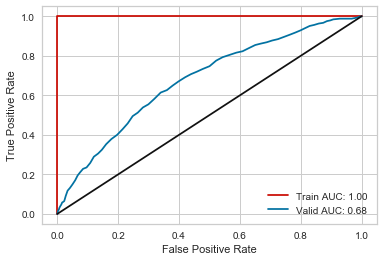

In [25]:
# Define X Values
x_tr = x_tr_svd_30
x_v = x_v_svd_30

train_model_default(clf, x_tr, x_v)

##### 300 Dimensions

In [26]:
# # Define X Values
# x_tr = x_tr_svd_300
# x_v = x_v_svd_300

# train_model_default(clf, x_tr, x_v)

### Gradient Boost Classifier

In [27]:
# Define Classifier - Default Settings
clf = GradientBoostingClassifier(random_state = random_state)

#### Pre SVD

In [28]:
# # Define X Values
# x_tr = x_tr_pre
# x_v = x_v_pre

# train_model_default(clf, x_tr, x_v)

#### Post SVD

##### 30 Dimensions

         Score  Train Validation
0          AUC  0.856      0.681
1     Accuracy  0.770      0.600
2    Precision  0.752      0.100
3       Recall  0.805      0.668
4           F1  0.389      0.087
5  Specificity  0.734      0.595
6   Prevalence  0.500      0.063


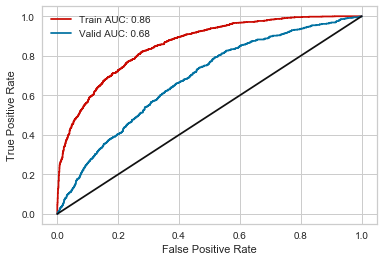

In [29]:
# Define X Values
x_tr = x_tr_svd_30
x_v = x_v_svd_30

train_model_default(clf, x_tr, x_v)

##### 300 Dimensions

In [30]:
# # Define X Values
# x_tr = x_tr_svd_300
# x_v = x_v_svd_300

# train_model_default(clf, x_tr, x_v)

### Ada Boost Classifier

In [31]:
# Define Classifier - Default Settings
clf = AdaBoostClassifier(random_state = random_state)

#### Pre SVD

In [32]:
# # Define X Values
# x_tr = x_tr_pre
# x_v = x_v_pre

# train_model_default(clf, x_tr, x_v)

#### Post SVD

##### 30 Dimensions

         Score  Train Validation
0          AUC  0.761      0.667
1     Accuracy  0.697      0.608
2    Precision  0.690      0.099
3       Recall  0.717      0.647
4           F1  0.352      0.086
5  Specificity  0.677      0.605
6   Prevalence  0.500      0.063


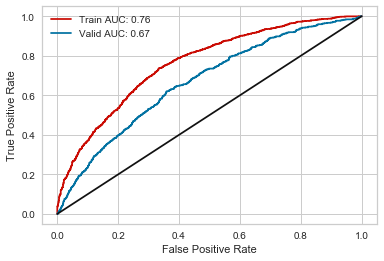

In [33]:
# Define X Values
x_tr = x_tr_svd_30
x_v = x_v_svd_30

train_model_default(clf, x_tr, x_v)

##### 300 Dimensions

In [34]:
# # Define X Values
# x_tr = x_tr_svd_300
# x_v = x_v_svd_300

# train_model_default(clf, x_tr, x_v)

### XGBoost

In [35]:
# Define Classifier - Default Settings
clf = XGBClassifier(random_state = random_state)

#### Pre SVD

In [36]:
# # Define X Values
# x_tr = x_tr_pre
# x_v = x_v_pre

# train_model_default(clf, x_tr, x_v)

#### Post SVD

##### 30 Dimensions

         Score  Train Validation
0          AUC  0.844      0.676
1     Accuracy  0.757      0.598
2    Precision  0.742      0.100
3       Recall  0.787      0.670
4           F1  0.382      0.087
5  Specificity  0.727      0.593
6   Prevalence  0.500      0.063


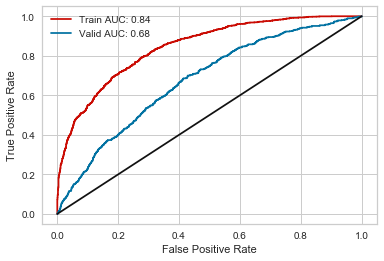

In [37]:
# Define X Values
x_tr = x_tr_svd_30
x_v = x_v_svd_30

train_model_default(clf, x_tr, x_v)

##### 300 Dimensions

In [38]:
# # Define X Values
# x_tr = x_tr_svd_30
# x_v = x_v_svd_30

# train_model_default(clf, x_tr, x_v)

## Parameter Optimization

After analyzing a suite of classifiers using default setting, the following four classifiers returned quality results, so we will move forward with these models.

* Naive Bayes
* KNNeighbors
* Logistic Regression
* Ada Boost Classifier
* Gradient Boost Classifier
* XGBoost Classifier

### Naive Bayes

Naive Bayes cannot use the dimensionally reduced matrices due to negative values.

#### Define Function Inputs

In [39]:
# Establish Classifier
clf = MultinomialNB()

#Define Parameters
alpha = np.logspace(-5, 5, 11)

# Create hyperparameter options
hyperparameters = dict(alpha = alpha)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    4.3s finished


Best parameters set found on training set:

{'alpha': 100.0}

0.603 (+/-0.031) for {'alpha': 1e-05}
0.603 (+/-0.031) for {'alpha': 0.0001}
0.603 (+/-0.031) for {'alpha': 0.001}
0.603 (+/-0.031) for {'alpha': 0.01}
0.603 (+/-0.031) for {'alpha': 0.1}
0.602 (+/-0.033) for {'alpha': 1.0}
0.603 (+/-0.042) for {'alpha': 10.0}
0.609 (+/-0.043) for {'alpha': 100.0}
0.605 (+/-0.037) for {'alpha': 1000.0}
0.606 (+/-0.037) for {'alpha': 10000.0}
0.607 (+/-0.037) for {'alpha': 100000.0}

         Score  Train Validation
0          AUC  0.679      0.662
1     Accuracy  0.629      0.642
2    Precision  0.638      0.104
3       Recall  0.597      0.616
4           F1  0.308      0.089
5  Specificity  0.661      0.644
6   Prevalence  0.500      0.063


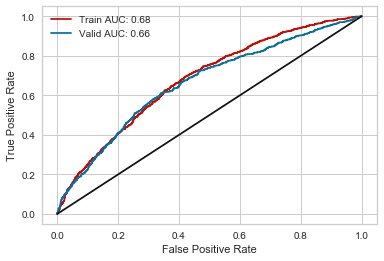

In [40]:
# Define X Values
x_tr = x_tr_pre
x_v = x_v_pre

clf = grid_search_opt(x_tr, x_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v)

# Define for Test Analysis
clf_nb_opt_pre = clf

### KNNeighbors

#### Define Function Inputs

In [41]:
# Establish Classifier
clf = KNeighborsClassifier()

#Define Parameters
n_neighbors  = np.linspace(3,30,10).astype('int') 
weights = ('uniform', 'distance')
metric = ('euclidean', 'manhattan')

# Create hyperparameter options
hyperparameters = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

#### Pre SVD

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


Best parameters set found on training set:

{'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}

0.592 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.592 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.586 (+/-0.024) for {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
0.594 (+/-0.020) for {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
0.599 (+/-0.024) for {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.599 (+/-0.024) for {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.612 (+/-0.036) for {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}
0.610 (+/-0.029) for {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'distance'}
0.620 (+/-0.031) for {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
0.621 (+/-0.032) for {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
0.615 (+/-0.029) for {'metric'

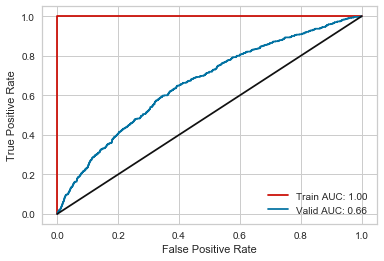

In [42]:
# Define X Values
x_tr = x_tr_pre
x_v = x_v_pre

clf = grid_search_opt(x_tr, x_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v)

# Define for Test Analysis
clf_knn_opt_pre = clf

### Logistic Regression

#### Define Function Inputs

In [43]:
# Establish Classifier
clf = LogisticRegression(random_state = random_state, solver = solver_log, max_iter = max_iter_log)

#Define Parameters
penalty = ['l1','l2']       
C = np.logspace(-5, 10, 16)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty = penalty)

#### Pre SVD

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 14.9min finished


Best parameters set found on training set:

{'C': 1.0, 'penalty': 'l2'}

0.333 (+/-0.000) for {'C': 1e-05, 'penalty': 'l1'}
0.346 (+/-0.050) for {'C': 1e-05, 'penalty': 'l2'}
0.333 (+/-0.000) for {'C': 0.0001, 'penalty': 'l1'}
0.597 (+/-0.042) for {'C': 0.0001, 'penalty': 'l2'}
0.333 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
0.615 (+/-0.039) for {'C': 0.001, 'penalty': 'l2'}
0.333 (+/-0.000) for {'C': 0.01, 'penalty': 'l1'}
0.622 (+/-0.037) for {'C': 0.01, 'penalty': 'l2'}
0.436 (+/-0.106) for {'C': 0.1, 'penalty': 'l1'}
0.653 (+/-0.017) for {'C': 0.1, 'penalty': 'l2'}
0.659 (+/-0.038) for {'C': 1.0, 'penalty': 'l1'}
0.662 (+/-0.031) for {'C': 1.0, 'penalty': 'l2'}
0.610 (+/-0.020) for {'C': 10.0, 'penalty': 'l1'}
0.638 (+/-0.030) for {'C': 10.0, 'penalty': 'l2'}
0.593 (+/-0.036) for {'C': 100.0, 'penalty': 'l1'}
0.603 (+/-0.042) for {'C': 100.0, 'penalty': 'l2'}
0.591 (+/-0.034) for {'C': 1000.0, 'penalty': 'l1'}
0.588 (+/-0.036) for {'C': 1000.0, 'penalty': 'l2'}
0.590 (+/-0.038) 

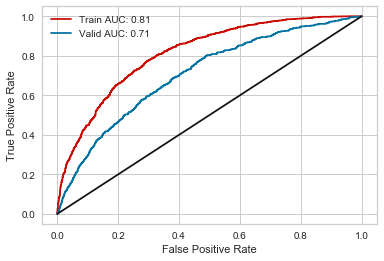

In [44]:
# Define X Values
x_tr = x_tr_pre
x_v = x_v_pre

clf = grid_search_opt(x_tr, x_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v)

# Define for Test Analysis
clf_logreg_opt_pre = clf

### Random Forest

Random Forest models have so far performed so-so, and have taken a very long time to run. For the training data it often overfits to match 100%. I recommend commenting out these models until final analysis

#### Define Function Inputs

In [45]:
# Establish Classifier
clf = RandomForestClassifier(random_state = random_state)

#Define Parameters
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 


# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, 
                       max_depth=max_depth,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf)

#### Pre SVD

In [46]:
# # Define X Values
# x_tr = x_tr_pre
# x_v = x_v_pre

# clf = grid_search_opt(x_tr, x_v, clf, hyperparameters)

# opt_model_scoring(clf, x_tr, x_v)

# # Define for Test Analysis
# clf_rf_opt_pre = clf

### Ada Boost

#### Define Function Inputs

In [47]:
# Define X Values
x_tr = x_tr_pre
x_v = x_v_pre

# Establish Classifier
clf = AdaBoostClassifier(random_state = random_state)

#Define Parameters
n_estimators = [25, 50, 100]
learning_rate = np.logspace(-4, -1, 4)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, 
                       learning_rate=learning_rate)

#### Pre SVD

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.1min finished


Best parameters set found on training set:

{'learning_rate': 0.1, 'n_estimators': 100}

0.598 (+/-0.045) for {'learning_rate': 0.0001, 'n_estimators': 25}
0.598 (+/-0.045) for {'learning_rate': 0.0001, 'n_estimators': 50}
0.598 (+/-0.045) for {'learning_rate': 0.0001, 'n_estimators': 100}
0.598 (+/-0.045) for {'learning_rate': 0.001, 'n_estimators': 25}
0.598 (+/-0.045) for {'learning_rate': 0.001, 'n_estimators': 50}
0.598 (+/-0.045) for {'learning_rate': 0.001, 'n_estimators': 100}
0.596 (+/-0.037) for {'learning_rate': 0.01, 'n_estimators': 25}
0.596 (+/-0.037) for {'learning_rate': 0.01, 'n_estimators': 50}
0.611 (+/-0.023) for {'learning_rate': 0.01, 'n_estimators': 100}
0.629 (+/-0.021) for {'learning_rate': 0.1, 'n_estimators': 25}
0.647 (+/-0.020) for {'learning_rate': 0.1, 'n_estimators': 50}
0.655 (+/-0.017) for {'learning_rate': 0.1, 'n_estimators': 100}

         Score  Train Validation
0          AUC  0.763      0.682
1     Accuracy  0.697      0.623
2    Precision  0.694

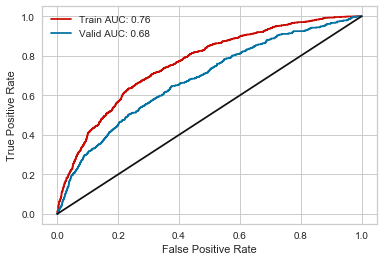

In [48]:
# Define X Values
x_tr = x_tr_pre
x_v = x_v_pre

clf = grid_search_opt(x_tr, x_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v)

# Define for Test Analysis
clf_ada_opt_pre = clf

### XGBoost

#### Define Function Inputs

In [49]:
# Establish Classifier
clf = XGBClassifier(random_state = random_state)

#Define Parameters
n_estimators = [25, 50, 100, 150]
learning_rate = np.logspace(-4, 1, 6)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate)

#### Pre SVD

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.9min finished


Best parameters set found on training set:

{'learning_rate': 0.03162277660168379, 'n_estimators': 100}

0.589 (+/-0.030) for {'learning_rate': 0.0001, 'n_estimators': 25}
0.589 (+/-0.030) for {'learning_rate': 0.0001, 'n_estimators': 50}
0.589 (+/-0.030) for {'learning_rate': 0.0001, 'n_estimators': 100}
0.606 (+/-0.029) for {'learning_rate': 0.0017782794100389228, 'n_estimators': 25}
0.609 (+/-0.026) for {'learning_rate': 0.0017782794100389228, 'n_estimators': 50}
0.610 (+/-0.026) for {'learning_rate': 0.0017782794100389228, 'n_estimators': 100}
0.633 (+/-0.030) for {'learning_rate': 0.03162277660168379, 'n_estimators': 25}
0.645 (+/-0.014) for {'learning_rate': 0.03162277660168379, 'n_estimators': 50}
0.653 (+/-0.022) for {'learning_rate': 0.03162277660168379, 'n_estimators': 100}
0.617 (+/-0.023) for {'learning_rate': 0.5623413251903491, 'n_estimators': 25}
0.614 (+/-0.030) for {'learning_rate': 0.5623413251903491, 'n_estimators': 50}
0.616 (+/-0.032) for {'learning_rate': 0.562341

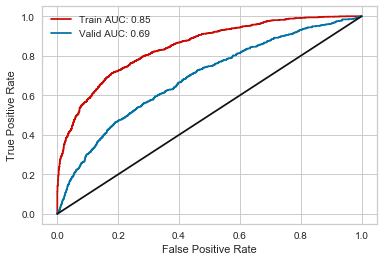

In [50]:
# Define X Values
x_tr = x_tr_pre
x_v = x_v_pre

clf = grid_search_opt(x_tr, x_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v)

# Define for Test Analysis
clf_xbg_opt_pre = clf

# Test Set Scoring

## General Function

In [51]:
def test_score (clf, x):
    
    print("Detailed classification report:")
    print()
    print("The model is trained and tuned on the training and validation sets..")
    print("The scores are computed on the test set.")
    print()
    y_true, y_pred = y_te, clf.predict(x)
    print(classification_report(y_true, y_pred))
    print()

In [52]:
def test_score_cv(clf, x):
    scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_macro']
    
    results = cross_validate(estimator = clf,
                                          X = x,
                                          y = y_te,
                                          cv = 5,
                                          scoring = scoring)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %f' % (metric_name, average_score))


## Naive Bayes

### Overall Metrics

In [53]:
test_score(clf_nb_opt_pre, x_te_pre)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0       0.96      0.64      0.76      8406
           1       0.11      0.60      0.18       619

    accuracy                           0.63      9025
   macro avg       0.53      0.62      0.47      9025
weighted avg       0.90      0.63      0.72      9025




### Cross Validation

In [54]:
test_score_cv(clf_nb_opt_pre, x_te_pre)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

fit_time : 0.150398
score_time : 0.068417
test_accuracy : 0.931413
test_balanced_accuracy : 0.500000
test_precision : 0.000000
test_recall : 0.000000
test_f1_macro : 0.482244


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## KNNeighbors

### Overall Metrics

In [55]:
test_score(clf_knn_opt_pre, x_te_pre)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0       0.96      0.65      0.77      8406
           1       0.11      0.60      0.19       619

    accuracy                           0.64      9025
   macro avg       0.53      0.62      0.48      9025
weighted avg       0.90      0.64      0.73      9025




### Cross Validation

In [56]:
test_score_cv(clf_knn_opt_pre, x_te_pre)

KeyboardInterrupt: 

## Logistic Regression

### Overall Metrics

In [ ]:
test_score(clf_logreg_opt_pre, x_te_pre)

### Cross Validation

In [ ]:
test_score_cv(clf_logreg_opt_pre, x_te_pre)

## Ada Boost

### Overall Metrics

In [ ]:
test_score(clf_ada_opt_pre, x_te_pre)

### Cross Validation

In [ ]:
test_score_cv(clf_ada_opt_pre, x_te_pre)

## XGBoost

### Overall Metrics

In [ ]:
test_score(clf_xbg_opt_pre, x_te_pre)

### Cross Validation

In [ ]:
test_score_cv(clf_xbg_opt_pre, x_te_pre)